imports

In [1]:
import os
#only print error messages from tensorflow
import tensorflow as tf
import numpy as np
import math
import time
import pickle
import bz2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler
import copy
from sklearn.metrics import mean_squared_error,mean_absolute_error
import scipy.optimize as opt
from itertools import chain

load data

In [ ]:
in_file = bz2.BZ2File("generated_data/full_generated_data.bz2",'rb')
data = pickle.load(in_file)
in_file.close()

print("data loaded")

In [ ]:
y_train = np.asarray(data[1])
x_test = np.asarray(data[2])
y_test = np.asarray(data[3])

y_scaler = MinMaxScaler(feature_range = (0,1))

scaled_x_test = np.asarray([x_scaler.fit_transform(x_test[i]) for i in range(len(x_test))])
# scaled_x_test = (x_test - np.min(x_test)) / np.max(x_test)
scaled_y_test = y_scaler.fit_transform(y_test)

In [ ]:
#https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

In [24]:
def analytical_eq(xy,xo,yo,No,T):   
    x, y = xy
    
    Nex = 100000-No
    
    out = (No/math.pi)*np.exp(-(x-xo)**2)*np.exp(-(y-yo)**2) + (Nex/(2*math.pi*T))*np.exp((-(x-xo)**2)/(2*T))*np.exp((-(y-yo)**2)/(2*T))
    out = (out - np.min(out)) / np.max(out)
    # out = No*np.exp(-(x-xo)**2)*np.exp(-(y-yo)**2) + (100000-No)*np.exp((-(x-xo)**2)/(2*T))*np.exp((-(y-yo)**2)/(2*T))
    return out.ravel()

In [305]:
x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)
np.min(analytical_eq((x,y),0,0,1000,150))

0.0

In [ ]:
x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)

test_im_indx = 100

initial_guess = (0,0,1000,1)

new_im = x_test[test_im_indx].ravel()

popt, _ = opt.curve_fit(analytical_eq, (x, y), new_im, p0=initial_guess)

In [ ]:
print(f"x_0: {popt[0]}, y_0: {popt[1]} , No: {popt[2]}, T: {popt[3]} ")

In [ ]:
data_fitted = analytical_eq((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.imshow(new_im.reshape(100, 100), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(100, 100), 12, colors='w')
plt.show()

In [ ]:
trained_model = tf.keras.models.load_model('BEC_model_conv')
ml_preds = trained_model.predict(scaled_x_test)
ml_preds = y_scaler.inverse_transform(ml_preds)

In [ ]:
initial_guess = (0,0,50000,175)
preds = []
for i,im in enumerate(x_test):
    popt, _ = opt.curve_fit(analytical_eq, (x, y), im.ravel(), p0=initial_guess)
    pred_No = popt[2]
    pred_T = popt[3]
    preds.append((pred_T,pred_No))

In [ ]:
ml_preds.shape
print(f" ml model num BEC atoms: {ml_preds[test_im_indx][1]}, ml model temp:{ml_preds[test_im_indx][0]}")
pred_gauss = analytical_eq((x,y),0,0,preds[test_im_indx][1],preds[test_im_indx][0])
pred_gauss = pred_gauss.reshape(100,100)

In [ ]:
print(f" fit model num BEC atoms: {popt[2]}, fit model temp:{popt[3]}")

In [ ]:
print(f" actual num atoms : {y_test[test_im_indx][1]}, actual temp : {y_test[test_im_indx][0]}")

In [ ]:
#fit gaussian vs noisy gaussian

row = 17

check = data_fitted.reshape(100,100)
plt.plot(np.arange(len(check[0])),check[row],label = "fit")
plt.plot(np.arange(len(check[0])),x_test[check_indx,row],label = "actual")
plt.plot(np.arange(len(check[0])),pred_gauss[row],label = "ml")
plt.legend()

In [ ]:
y_test[test_im_indx]

In [ ]:
preds = np.asarray(preds)
preds.shape

In [ ]:
fit_T_rmse = mean_squared_error(preds[:,0],y_test[:,0],squared = False)

In [ ]:
fit_N_rmse = mean_squared_error(preds[:,1],y_test[:,1],squared = False)

In [ ]:
fit_T_rmse

In [ ]:
fit_N_rmse

In [ ]:
ml_T_rmse = mean_squared_error(ml_preds[:,0],y_test[:,0],squared = False)

In [ ]:
ml_N_rmse = mean_squared_error(ml_preds[:,1],y_test[:,1],squared = False)

In [ ]:
ml_T_rmse

In [ ]:
ml_N_rmse

### see if scipy beats ml at different temperatures

In [ ]:
def filter_by_temperature(floor,ceil, x, y):
    xy_combos = list(zip(x,y))
    xy_combos = np.asarray(list(filter(lambda tup: ceil > tup[1][0] > floor ,xy_combos)),dtype = object)
    high_temp_x_test, high_temp_y_test = xy_combos.T
    high_temp_x_test = np.asarray(list(chain(*zip(high_temp_x_test))))
    high_temp_y_test = np.asarray(list(chain(*zip(high_temp_y_test))))
    
    return high_temp_x_test, high_temp_y_test

In [ ]:
high_temp_x_test, high_temp_y_test = filter_by_temperature(0,150,x_test,y_test)

#### Scipy

In [ ]:
initial_guess = (0,0,50000,175)
high_temp_preds = []
for i,im in enumerate(high_temp_x_test):
    popt, _ = opt.curve_fit(analytical_eq, (x, y), im.ravel(), p0=initial_guess)
    pred_No = popt[2]
    pred_T = popt[3]
    if pred_No < 0:
        pred_No = 0
    if pred_T < 0:
        pred_T = 0
    high_temp_preds.append((pred_T,pred_No))
        
high_temp_preds = np.asarray(high_temp_preds)

In [ ]:
fit_high_temp_T_rmse = mean_squared_error(high_temp_preds[:,0],high_temp_y_test[:,0],squared = False)

In [ ]:
fit_high_temp_N_rmse = mean_squared_error(high_temp_preds[:,1],high_temp_y_test[:,1],squared = False)

In [ ]:
fit_high_temp_T_rmse

In [ ]:
fit_high_temp_N_rmse

#### ML

In [ ]:
trained_model = tf.keras.models.load_model('BEC_model_conv')

x_scaler = MinMaxScaler(feature_range = (0,1))
y_scaler = MinMaxScaler(feature_range = (0,1))

scaled_ht_x_test = np.asarray([x_scaler.fit_transform(high_temp_x_test[i]) for i in range(len(high_temp_x_test))])
scaled_ht_y_test = y_scaler.fit_transform(high_temp_y_test)

In [ ]:
ht_ml_preds = trained_model.predict(scaled_ht_x_test)
ht_ml_preds = y_scaler.inverse_transform(ht_ml_preds)

In [ ]:
ht_ml_T_rmse = mean_squared_error(ht_ml_preds[:,0],high_temp_y_test[:,0],squared = False)

In [ ]:
ht_ml_N_rmse = mean_squared_error(ht_ml_preds[:,1],high_temp_y_test[:,1],squared = False)

In [ ]:
print(high_temp_preds[0])
print(ht_ml_preds[0])
print(high_temp_y_test[0])

In [ ]:
ht_ml_T_rmse

In [ ]:
ht_ml_N_rmse

In [ ]:
#see if scipy works better at higher resolution image

In [254]:
num_atoms = 100000
temp_ratio = (num_atoms/(2*1*1.645))**0.5
length = 1000
dimensions = 2
        
        
def generate_image(temp_ratio,length,num_atoms,dimensions):
    '''
    generate image using sampling
    '''

    x_list = []
    y_list = []
    
    trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
    
    temp = np.random.uniform(trans_temp//2,int(trans_temp*2))

    num_BEC_atoms = 0
    if temp < trans_temp:
        num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
    
    for i in range(num_atoms):
        probability = np.random.rand()
        if temp_ratio >1 :
            temp_ratio = 1
        BEC_probability = (1-(temp_ratio)**dimensions)
        if probability <= BEC_probability:
            x_list.append((1/(math.sqrt(math.pi)))*np.random.normal(0,math.sqrt(1/2)))
            y_list.append((1/(math.sqrt(math.pi)))*np.random.normal(0,math.sqrt(1/2)))

        else:
            x_list.append((1/(math.sqrt(2 * math.pi)))*np.random.normal(0,math.sqrt(temp)))
            y_list.append((1/(math.sqrt(2 * math.pi)))*np.random.normal(0,math.sqrt(temp)))



    hist = np.histogram2d(x_list,y_list,length)[0]
    hist = hist.tolist()
    return hist,temp,num_BEC_atoms

test_im_count = 1
test_ims = []
labs = []
for i in range(test_im_count):
    curr_im, t, n = generate_image(temp_ratio,length,num_atoms,dimensions)
    
    test_ims.append(np.asarray(curr_im))
    labs.append((t,n))

test_ims = np.stack(test_ims)

In [258]:
test_ims[0] = (test_ims[0] - np.min(test_ims[0])) / np.max(test_ims[0])

In [259]:
indx = 0

x = np.linspace(-length//2+1, length//2, length)
y = np.linspace(-length//2+1, length//2, length)
x, y = np.meshgrid(x, y)

initial_guess = (0,0,1000,1)

check_im = test_ims[indx]

new_im = check_im.ravel()

popt, _ = opt.curve_fit(analytical_eq, (x, y), new_im, p0=initial_guess)

In [260]:
labs = np.stack(labs)
labs.shape

(1, 2)

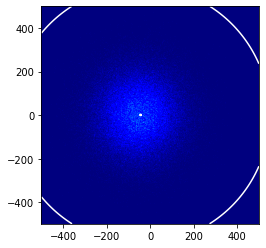

In [265]:
data_fitted = analytical_eq((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.imshow(new_im.reshape(length, length), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(length, length), 30, colors='w')
plt.show()

In [266]:
popt

array([-4.26316432e+01,  9.80271658e-01,  1.38977089e+00,  8.67216911e+05])

In [267]:
labs[indx]

array([238.75456254,   0.        ])

In [ ]:
initial_guess = (0,0,50000,175)
ng_preds = []
for i,im in enumerate(test_ims):
    popt, _ = opt.curve_fit(analytical_eq, (x, y), im.ravel(), p0=initial_guess)
    pred_No = popt[2]
    pred_T = popt[3]
    if pred_No < 0:
        pred_No = 0
    if pred_T < 0:
        pred_T = 0
    ng_preds.append((pred_T,pred_No))
        
ng_preds = np.asarray(ng_preds)

In [ ]:
ng_preds[indx]

In [ ]:
labs[indx]

In [ ]:
print(labs.shape)

In [ ]:
ng_fit_T_rmse

In [ ]:
ng_fit_N_rmse = mean_squared_error(ng_preds[:,1],labs[:,1],squared = False)

In [ ]:
ng_fit_N_rmse

In [ ]:
### figure out how to get scipy working well
#goal is ~1 temp rmse ~150 n rmse

In [5]:
num_atoms = 100000
length = 100
dimensions = 2
        
        
def generate_image(length,num_atoms,dimensions):
    '''
    generate image using sampling
    '''

    x_list = []
    y_list = []
    
    trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
    
    # temp = np.random.uniform(trans_temp//2,int(trans_temp*2))
    temp = 150
    
    temp_ratio = temp/trans_temp

    num_BEC_atoms = 0
    if temp < trans_temp:
        num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
        
    count = 0
    
    for i in range(num_atoms):
        probability = np.random.rand()
        if temp_ratio >1 :
            temp_ratio = 1
        BEC_probability = (1-(temp_ratio)**dimensions)
        if probability <= BEC_probability:
            count += 1
            x_list.append((1/(math.sqrt(math.pi)))*np.random.normal(0,math.sqrt(1/2)))
            y_list.append((1/(math.sqrt(math.pi)))*np.random.normal(0,math.sqrt(1/2)))

        else:
            x_list.append((1/(math.sqrt(2 * math.pi)))*np.random.normal(0,math.sqrt(temp)))
            y_list.append((1/(math.sqrt(2 * math.pi)))*np.random.normal(0,math.sqrt(temp)))



    hist = np.histogram2d(x_list,y_list,length)[0]
    hist = hist.tolist()
    return hist,temp,num_BEC_atoms,count

test_im_count = 100
test_ims = []
labs = []
for i in range(test_im_count):
    curr_im, t, n, count = generate_image(length,num_atoms,dimensions)
    
    test_ims.append(np.asarray(curr_im))
    labs.append((t,n,count))

test_ims = np.stack(test_ims)
labs = np.stack(labs)

In [16]:
test_ims.shape

(100, 100, 100)

In [17]:
mean_test_im = np.mean(test_ims,axis = 0)

In [18]:
mean_test_im = (mean_test_im - np.min(mean_test_im)) / np.max(mean_test_im)

In [19]:
np.min(mean_test_im)

0.0

In [27]:
x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)

num_atoms = 100000
dimensions = 2
temp = 150

trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)

actual = analytical_eq((x,y),0,0,num_BEC_atoms,temp)

In [37]:
length = 100
actual = np.reshape(actual,(length,length))
actual.shape

(100, 100)

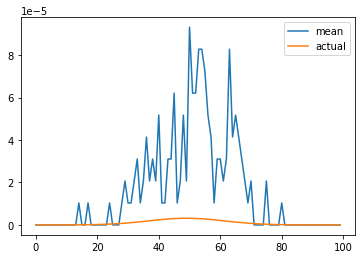

In [45]:
#mean gaussian

row = 0

plt.plot(np.arange(len(mean_test_im[0])),mean_test_im[row],label = "mean")
plt.plot(np.arange(len(mean_test_im[0])),actual[row],label = "actual")
plt.legend()

In [306]:
indx = 0

x = np.linspace(-length//2+1, length//2, length)
y = np.linspace(-length//2+1, length//2, length)
x, y = np.meshgrid(x, y)

initial_guess = (5,0,40000,150)

check_im = test_ims[indx]

new_im = check_im.ravel()

popt, _ = opt.curve_fit(analytical_eq, (x, y), new_im, p0=initial_guess,bounds = ([-np.inf,-np.inf,0,0],[np.inf,np.inf,100000,360]))

In [307]:
popt

array([ 4.97005080e+00, -4.09634622e-01,  2.69244241e+04,  6.44691250e+00])

In [308]:
labs[indx]

array([  138.05248881, 37297.56899456, 37459.        ])

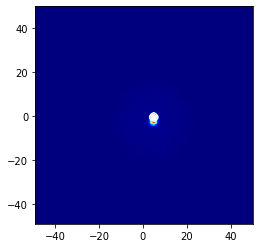

In [310]:
data_fitted = analytical_eq((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.imshow(new_im.reshape(length, length), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(length, length), 5, colors='w')
plt.show()

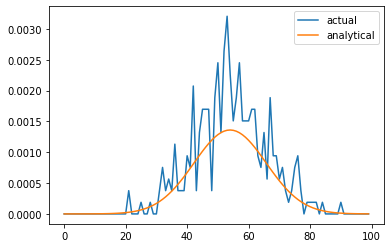

In [340]:
#fit gaussian vs noisy gaussian

row = 70

analytical_gaussian_image = analytical_eq((x,y),popt[0],popt[1],labs[indx][1],labs[indx][0]).reshape(length,length)

check = data_fitted.reshape(length,length)
# plt.plot(np.arange(len(check[0])),check[row],label = "fit")
plt.plot(np.arange(len(check[0])),test_ims[indx,row],label = "actual")
plt.plot(np.arange(len(check[0])),analytical_gaussian_image[row],label = "analytical")
plt.legend()

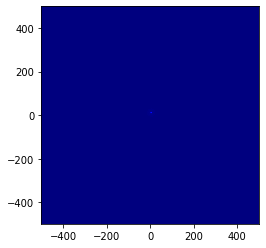

In [252]:
fig, ax = plt.subplots(1, 1)
ax.imshow(analytical_gaussian_image, cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
plt.show()

In [ ]:
initial_guess = (0,0,50000,175)
ng_preds = []
origins = []
for i,im in enumerate(test_ims):
    popt, _ = opt.curve_fit(analytical_eq, (x, y), im.ravel(), p0=initial_guess)
    xo,yo = popt[:2]
    pred_No = popt[2]
    pred_T = popt[3]
    if pred_No < 0:
        pred_No = 0
    if pred_T < 0:
        pred_T = 0
    ng_preds.append((pred_T,pred_No))
    origins.append((xo,yo))
        
ng_preds = np.asarray(ng_preds)

In [ ]:
ng_preds[0]

In [ ]:
labs[5]

In [ ]:
ng_fit_N_rmse = mean_squared_error(ng_preds[:,-1],labs[:,1],squared = False)

In [ ]:
ng_fit_N_rmse

In [ ]:
ng_preds[5]

In [ ]:
labs[0]

In [ ]:
origins[indx]

In [ ]:
#fit gaussian vs noisy gaussian

row = 50


check = data_fitted.reshape(100,100)
plt.plot(np.arange(len(check[0])),check[row],label = "fit")
plt.plot(np.arange(len(check[0])),test_ims[indx,row],label = "actual")
plt.legend()

In [ ]:
labs[indx]

In [ ]:
test_ims[indx,:,col]

In [ ]:
np.max(test_ims[indx])

In [ ]:
num_atoms = 100000
temp_ratio = (num_atoms/(2*1*1.645))**0.5
length = 100
dimensions = 2

x = np.linspace(-length//2+1, length//2, length)
y = np.linspace(-length//2+1, length//2, length)
x, y = np.meshgrid(x, y)

        
        
def generate_image_without_sampling(temp_ratio,length,num_atoms,dimensions,x,y):

    res = np.zeros((length,length))
    
    trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
    
    temp = np.random.uniform(trans_temp//2,int(trans_temp*2))

    num_BEC_atoms = 0
    if temp < trans_temp:
        num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
        
    for i in range(length):
        for j in range(length):

            res[i,j] = (num_BEC_atoms/math.pi)*np.exp(-(x[i,j])**2)*np.exp(-(y[i,j])**2) + ((100000-num_BEC_atoms)/(2*math.pi*temp))*np.exp((-(x[i,j])**2)/(2*temp))*np.exp((-(y[i,j])**2)/(2*temp)) + np.random.normal()

    return res,temp,num_BEC_atoms

test_im_count = 100
test_ims = []
labs = []
for i in range(test_im_count):
    curr_im, t, n = generate_image_without_sampling(temp_ratio,length,num_atoms,dimensions,x,y)
    
    test_ims.append(np.asarray(curr_im))
    labs.append((t,n))

test_ims = np.stack(test_ims)
labs = np.stack(labs)

In [ ]:
initial_guess = (0,0,50000,175)
ng_preds = []
origins = []
for i,im in enumerate(test_ims):
    popt, _ = opt.curve_fit(analytical_eq, (x, y), im.ravel(), p0=initial_guess)
    xo,yo = popt[:2]
    pred_No = popt[2]
    pred_T = popt[3]
    if pred_No < 0:
        pred_No = 0
    if pred_T < 0:
        pred_T = 0
    ng_preds.append((pred_T,pred_No))
    origins.append((xo,yo))
        
ng_preds = np.asarray(ng_preds)

In [ ]:
check_indx = 5

In [ ]:
data_fitted = analytical_eq((x, y), *origins[check_indx],*ng_preds[check_indx][::-1])

fig, ax = plt.subplots(1, 1)
ax.imshow(test_ims[0].reshape(100, 100), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(100, 100),10, colors='w')
plt.show()

In [ ]:
#fit gaussian vs noisy gaussian

col = 49

check = data_fitted.reshape(100,100)
plt.plot(np.arange(len(check[0])),check[:,col],label = "fit")
plt.plot(np.arange(len(check[0])),test_ims[check_indx,:,col],label = "actual")
plt.legend()

In [ ]:
labs[check_indx]

In [ ]:
ng_preds[check_indx]

In [ ]:
ng_fit_T_rmse = mean_squared_error(ng_preds[:,0],labs[:,0],squared = False)

In [ ]:
ng_fit_T_rmse

In [ ]:
ng_fit_N_rmse = mean_squared_error(ng_preds[:,1],labs[:,1],squared = False)

In [ ]:
ng_fit_N_rmse